# Working with ASF processed RTC imagery: `open_mfdataset()` approach

This is a notebook demonstrates working with Sentinel-1 RTC imagery that has been processsed on the ASF On-Demand server and downloaded locally. 

The access point for data in this notebook is a directory containing un-zipped directories of RTC scenes.
```{note}
worth including image of directory structure here?
```

As stated before, this tutorial contains examples of two approaches to working with locally-downloaded ASF-processed Sentinel-1 RTC imagery. This notebook will detail how to use the xarray function `.open_mfdataset()`. While this approach works and is very useful for working with large stacks of data with associated metadata, you will also see an example of the limitations of this approach due to certain characteristics of the dataset. You can read more about `xr.open_mfdataset()` [here](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html).

**Learning goals**:

Handling large amounts of locally stored data
- organize large set of geotiff files stored locally
- multiple methods for reading data into python as `xarray` objects
    - xarray `open_mfdataset()`
    
**NOTE**: code for submitting HyP jobs still needs to be added back in

## Software and setup

In [2]:
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask


We'll use this function later but defining it now:

In [3]:
# read in PC data (We will use this later for a comparison)
#we'll use this function to get bounding box coordinates from a list of points 
def points2coords(pt_ls): #should be [xmin, ymin, xmax, ymax]
    
    coords_ls = [(pt_ls[0], pt_ls[1]), (pt_ls[0], pt_ls[3]),
                 (pt_ls[2], pt_ls[3]), (pt_ls[2], pt_ls[1]),
                 (pt_ls[0], pt_ls[1])]
    return coords_ls
    



Initialize a `dask.distributed` client:

```{admonition} Head's up! 
On my local machine, I ran into issues initially when the cluster was running on processes rather than threads. This caused system memory issues and many dead kernels. Setting `processes=False` seemed to fix these issues
```

In [4]:
from dask.distributed import Client

client = Client(processes=False) #look into limiting memory
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.86.35:8787/status,
Dashboard: http://192.168.86.35:8787/status,Workers: 1
Total threads: 16,Total memory: 14.96 GiB
Status: running,Using processes: False
Comm: inproc://192.168.86.35/58682/1,Workers: 1
Dashboard: http://192.168.86.35:8787/status,Total threads: 16
Started: Just now,Total memory: 14.96 GiB
Comm: inproc://192.168.86.35/58682/4,Total threads: 16
Dashboard: http://192.168.86.35:44717/status,Memory: 14.96 GiB
Nanny: None,


Open the dask dashboard at the link above to monitor task progress.

Set up some string variables for directory paths. We need to pass `xr.open_mfdataset()` a list of all files to read in. Currently, the file structure is organized so that each scene has its own sub-directory within `unzipped_keep`. Within each sub-directory are several files - we want to extract the tif files containing RTC imagery for the VV and VH polarizations for each scene. The function `extract_tif_fnames()` takes a path to the directory containing the sub-directories for all scenes and returns a list of the filenames for VV-polarization tif files and a separate list of filenames for VH-polarization tif files.

In [5]:
dir_path_all = '/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/'
scenes_ls = os.listdir(dir_path_all)

def extract_tif_fnames(scene_path):
    ''' return a list of files associated with a single S1 scene'''
    scene_files_ls = os.listdir(dir_path_all + scene_path)
    
    scene_files_vv = [fname for fname in scene_files_ls if fname.endswith('_VH.tif')]
    scene_files_vh = [fname for fname in scene_files_ls if fname.endswith('_VV.tif')]
    scene_files_ls = [fname for fname in scene_files_ls if fname.endswith('_ls_map.tif')]
    
    return scene_files_vv, scene_files_vh, scene_files_ls

Now we need to attach the filenames to the full path to each file. We will end up with a list of 

In [6]:
fpaths_vv, fpaths_vh, fpaths_ls = [],[],[]

for element in range(len(scenes_ls)):
    
    good_files = extract_tif_fnames(scenes_ls[element])
    
    path_vh = dir_path_all + scenes_ls[element] + '/' + good_files[0][0]
    path_vv = dir_path_all + scenes_ls[element] + '/' + good_files[1][0]
    path_ls = dir_path_all + scenes_ls[element] + '/' + good_files[2][0]
    
    fpaths_vv.append(path_vv)
    fpaths_vh.append(path_vh)
    fpaths_ls.append(path_ls)

## Read in files using `xr.open_mfdataset()`

The xarray `open_mfdataset()` function reads multiple files (in a directory or from a list) and combines them to return a single `xr.Dataset` or `xr.DataArray`. To use the function, specify paramters such as how the files should be combined as well as any preprocessing to execute on the original files. This example will demonstrate a workflow for using `open_mfdataset()` to read in two stacks of roughly 100 RTC images.

`preprocess_vv` and `preprocess_vh` are identical but for vv and vh bands (read from different tif files). `preprocess_ls` reads in the layover shadow masks that are provided with each scene and similarly stored as tiff files.


```{note}
consider combining these into one preprocess function with an input parameter for variable (VV, VH, LS)?
```

In [12]:
def preprocess_vv(da_orig):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think? 
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''

    
    da = da_orig.copy()
    da = da.rename({'band_data':'vv'}).squeeze()
    
    vv_fn = da_orig.encoding['source'][113:]
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID
    
    attrs_dict = { 'sensor': sensor,
                    'beam_mode':beam_mode, 
                    'acquisition_date' : acq_date,
                    'acquisition_time': acq_time,
                    'polarisation_type': pol_type,
                    'primary_polarisation': primary_pol,
                    'orbit_type': orbit_type,
                    'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                    'output_format': output,
                    'output_type': output_type,
                    'masked' : masked,
                    'filtered':filtered,
                    'area':area,
                    'product_id': product_id 
             }
                    
    #link the strings for each of the above variables to their full names (from README, commented above)
    #eg if output_type=g, should read 'gamma'
    #add these as attrs to xr obj, make into dict first? 
    # parse acq_date to datetime, add as dim and coordinate to xr obj
    #add other metadata vars as attributes to xr obj
    
    da.attrs = attrs_dict
    
    utm_zone = da.spatial_ref.attrs['crs_wkt'][17:29]
    epsg_code =da.spatial_ref.attrs['crs_wkt'][589:594]
    
    da.attrs['utm_zone'] = utm_zone
    da.attrs['epsg_code'] = f'EPSG:{epsg_code}'
    
    date = da.attrs['acquisition_date']
    
    da = da.assign_coords({'acq_date':date})
    da = da.expand_dims('acq_date')
    da = da.drop_duplicates(dim=['x','y'])
    
    #vec = gpd.read_file('https://github.com/e-marshall/s1_book/raw/main/data/hma_lakes_aoi.geojson')
    #print(vec.crs)
    #da_clip = da.rio.clip(vec.geometry, vec.crs, drop=True)
    #print(da_clip.crs)
    
    return da

In [13]:
def preprocess_vh(da_orig):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think? 
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''

    
    da = da_orig.copy()
    da = da.rename({'band_data':'vh'}).squeeze()
   
    vv_fn = da_orig.encoding['source'][113:]
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID
    
    attrs_dict = { 'sensor': sensor,
                    'beam_mode':beam_mode, 
                    'acquisition_date' : acq_date,
                    'acquisition_time': acq_time,
                    'polarisation_type': pol_type,
                    'primary_polarisation': primary_pol,
                    'orbit_type': orbit_type,
                    'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                    'output_format': output,
                    'output_type': output_type,
                    'masked' : masked,
                    'filtered':filtered,
                    'area':area,
                    'product_id': product_id 
             }
                    
    #link the strings for each of the above variables to their full names (from README, commented above)
    #eg if output_type=g, should read 'gamma'
    #add these as attrs to xr obj, make into dict first? 
    # parse acq_date to datetime, add as dim and coordinate to xr obj
    #add other metadata vars as attributes to xr obj
    
    da.attrs = attrs_dict
    
    utm_zone = da.spatial_ref.attrs['crs_wkt'][17:29]
    epsg_code =da.spatial_ref.attrs['crs_wkt'][589:594]
    
    da.attrs['utm_zone'] = utm_zone
    da.attrs['epsg_code'] = f'EPSG:{epsg_code}'
    
    date = da.attrs['acquisition_date']
    
    da = da.assign_coords({'acq_date':date})
    da = da.expand_dims('acq_date')
    da = da.drop_duplicates(dim=['x','y'])
    
    return da

In [14]:
def preprocess_ls(da_orig):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think? 
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''

    
    da = da_orig.copy()
    da = da.rename({'band_data':'layover_shadow_mask'}).squeeze()
    
    vv_fn = da_orig.encoding['source'][113:]
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID
    
    attrs_dict = { 'sensor': sensor,
                    'beam_mode':beam_mode, 
                    'acquisition_date' : acq_date,
                    'acquisition_time': acq_time,
                    'polarisation_type': pol_type,
                    'primary_polarisation': primary_pol,
                    'orbit_type': orbit_type,
                    'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                    'output_format': output,
                    'output_type': output_type,
                    'masked' : masked,
                    'filtered':filtered,
                    'area':area,
                    'product_id': product_id 
             }
                    
    #link the strings for each of the above variables to their full names (from README, commented above)
    #eg if output_type=g, should read 'gamma'
    #add these as attrs to xr obj, make into dict first? 
    # parse acq_date to datetime, add as dim and coordinate to xr obj
    #add other metadata vars as attributes to xr obj
    
    da.attrs = attrs_dict
    
    utm_zone = da.spatial_ref.attrs['crs_wkt'][17:29]
    epsg_code =da.spatial_ref.attrs['crs_wkt'][589:594]
    
    da.attrs['utm_zone'] = utm_zone
    da.attrs['epsg_code'] = f'EPSG:{epsg_code}'
    
    date = da.attrs['acquisition_date']
    
    da = da.assign_coords({'acq_date':date})
    da = da.expand_dims('acq_date')
    da = da.drop_duplicates(dim=['x','y'])
    
    #vec = gpd.read_file('https://github.com/e-marshall/s1_book/raw/main/data/hma_lakes_aoi.geojson')
    #print(vec.crs)
    #da_clip = da.rio.clip(vec.geometry, vec.crs, drop=True)
    #print(da_clip.crs)
    
    return da

First, let's call `xr.open_mfdataset()` with the argument `chunks='auto'`. This will read in a dask array where ideal chunk sizes are selected based off the array size, it will attempt to have chunk sizes where bytes are equal to the configuration value for array chunk size. More about that [here](https://docs.dask.org/en/stable/array-chunks.html#automatic-chunking).You can check the configuration value for an array chunk size with the code below: 

In [15]:
dask.config.get('array.chunk-size')

'128MiB'

In [16]:
asf_vh = xr.open_mfdataset(paths = fpaths_vh, preprocess = preprocess_vh, chunks = 'auto', engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='acq_date', combine='nested', parallel=True)

In [17]:
asf_vh

,Array,Chunk
Bytes,89.59 GiB,73.81 MiB
Shape,"(103, 13379, 17452)","(1, 3921, 4935)"
Count,1338 Graph Layers,317240 Chunks
Type,float32,numpy.ndarray


If we take a look at the `asf_vh` object we just created (click the stack icon on the right of the `vh` variable tab), we see that the chunking is quite complicated. This isn't ideal because it can create problems like excessive communication between workers (?) (and a lot of memory usage) down the line when we perform non-lazy operations. It seems like the `'auto'` chunking is applied to the top layer (file) of the dataset, but because the spatial footprint of each file is not the same, the 'auto' chunking does not persist through layers and we end up with the funky layout in the object above. 

Let's create both the VV and VH objects with `chunks=None` and see how it looks:

In [18]:
asf_vh = xr.open_mfdataset(paths = fpaths_vh, preprocess = preprocess_vh, chunks = None, engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='acq_date', combine='nested', parallel=True)

In [19]:
asf_vv= xr.open_mfdataset(paths = fpaths_vv, preprocess = preprocess_vv, chunks = None, engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='acq_date', combine='nested', parallel=True)

In [20]:
asf_ls = xr.open_mfdataset(paths = fpaths_ls, preprocess = preprocess_ls, chunks=None, engine='rasterio', data_vars='minimal', coords='minimal', concat_dim = 'acq_date', combine='nested', parallel=True)


Now our chunks are quite large, but they are at least in a format that makes more sense for our dataset. This will make it easier to clip the object to our area of interest, which will solve the problem of large chunks

In [21]:
asf_vv

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

In [22]:
asf_vh

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

In [23]:
asf_ls

<xarray.Dataset>
Dimensions:              (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x                    (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y                    (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date             (acq_date) datetime64[ns] 2021-08-21 ... 2022-04-06
    band                 int64 1
    spatial_ref          int64 0
Data variables:
    layover_shadow_mask  (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

Merge the VH, VV and layover-shadow mask objects into one `xr.Dataset`:

In [24]:
asf_ds = xr.Dataset({'vv':asf_vv.vv, 'vh':asf_vh.vh, 'ls':asf_ls.layover_shadow_mask})
asf_ds

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    ls           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>

If you take a look at the `acq_date` coordinate, you will see that they are not in order. Let's sort by the `acq_date` (time) dimension using xarray `.sortby()`:

In [25]:
asf_ds_sorted = asf_ds.sortby(asf_ds.acq_date)
asf_ds_sorted

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    ls           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>

### Clip stack to AOI

This is a pretty unwieldly object (nearly 200 GB). Let's subset it down to just the area we want to focus on. First, we will read in the comparison dataset of S-1 RTC imagery processed by Planetary Computer and use the spatial footprint of that dataset to subset our ASF RTC stack. 

In [26]:
#pc_aoi = gpd.read_file('https://github.com/e-marshall/s1_book/raw/main/data/hma_lakes_aoi.geojson')
pc_aoi = gpd.read_file('/home/emmamarshall/Desktop/siparcs/s1_book/data/hma_lakes_aoi.geojson')
pc_aoi

,geometry
0,"POLYGON ((619420.000 3089790.000, 628100.000 3..."


<AxesSubplot:>

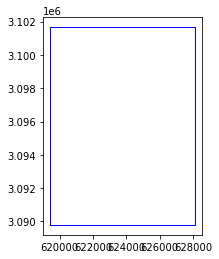

In [27]:
pc_aoi.plot(facecolor='None', edgecolor='blue')

In [28]:
asf_clip = asf_ds_sorted.rio.clip(pc_aoi.geometry, pc_aoi.crs)

Check the size of the clipped object:

In [29]:
asf_clip.nbytes/1e6

141.948568

In [30]:
#asf_clip_copy = asf_clip.copy()

In [31]:
%store asf_clip

Stored 'asf_clip' (Dataset)


In [32]:
#asf_clip_copy.to_netcdf('asf_clip_wls_99.nc')

In [33]:
#we don't want to compute this right now, will kill kernel
#asf_clip_load = asf_clip.compute()

Taking a quick look at the VH, VV and mask variables for a few different time steps, it looks lie several time steps have a fair amount of missing data. Let's confirm this and then remove datasets that are missing data above a certain threshold.

In [34]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

In [35]:
str(asf_clip.isel(acq_date=10).acq_date.data)[:-19]

'2021-06-07'

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(18,7))

asf_clip.isel(acq_date=10).ls.plot(ax=axs[0]);
power_to_db(asf_clip.isel(acq_date=10).vv).plot(ax=axs[1], cmap = plt.cm.Greys_r);
power_to_db(asf_clip.isel(acq_date=10).vh).plot(ax=axs[2], cmap = plt.cm.Greys_r);

fig.suptitle(f'Layover-shadow mask (L), VV (C) and VH (R) backscatter on {str(asf_clip.isel(acq_date=10).acq_date.data)[:-19]}')

**layover shadow mask interpreation**:

the values are a summation of 17 possible pixel values:

0 - not tested for layover or shadow
1 - not affected by layover or shadow

3 - look angle < slope angle

5 - affected by layover

7 - affected by layover, look angle < slope

9 - look angle < opposite slope angle

11 - look angle < slope and opposite slope angle

13 - affected by layover; look angle < opposite slope angle

15 - affected by layover; look angle < slope and opposite slope angle

17 - affected by shadow

19 - affected by shadow; look angle < slope angle

21 - affected by layover and shadow

23 - 

Let's write a quick function to take a look at a similar breakdown for other time steps more easily:

In [31]:
def plot_timestep(input_arr, time_step_int):
    
    fig, axs = plt.subplots(ncols=3, figsize=(18,7))

    input_arr.isel(acq_date=time_step_int).ls.plot(ax=axs[0]);
    power_to_db(input_arr.isel(acq_date=time_step_int).vv).plot(ax=axs[1], cmap = plt.cm.Greys_r);
    power_to_db(input_arr.isel(acq_date=time_step_int).vh).plot(ax=axs[2], cmap = plt.cm.Greys_r);

    fig.suptitle(f'Layover-shadow mask (L), VV (C) and VH (R) backscatter {str(asf_clip.isel(acq_date=time_step_int).acq_date)[:-19]}')
    

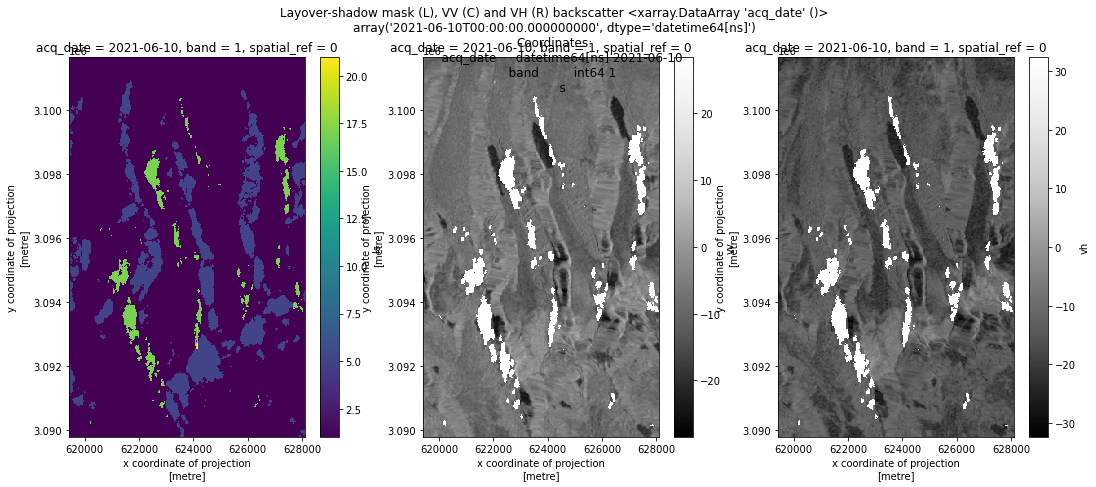

In [32]:
plot_timestep(asf_clip, 11)

It looks like there are some interesting differences between the geometric distortions within the two images. Let's take a look at them side-by-side:

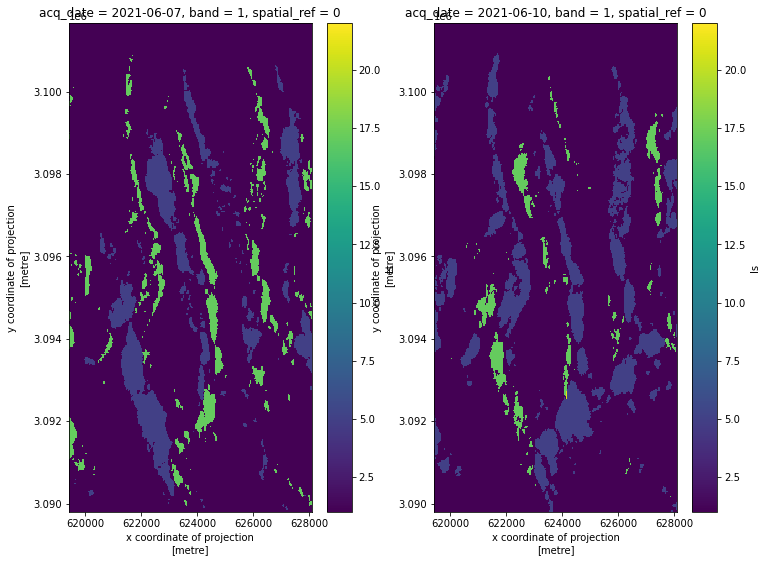

In [34]:
fig, axs = plt.subplots(ncols=2, figsize=(12,9))

asf_clip.isel(acq_date=10).ls.plot(ax=axs[0], vmax = 22, vmin = 1);
asf_clip.isel(acq_date=11).ls.plot(ax=axs[1], vmax = 22, vmin = 1 );

It looks like there are areas affected by different distortion effects on different dates. For example, in the lower left quadrant, there is a region that is blue (5) on 6/7/2010 but most of that area appears green (19) on 6/10/2010. On 6/7, that area is affected by layover, but on 6/10 much of that same area seems to be in the radar shadow. 

```{note}
I thought you couldn't extract reliable data from pixels with layover? In these images there are values for those pixels but they have a blurred look
```

This approach works but it is not very computationally efficient. We are reading in a vast footprint of data to subset it to a much smaller area. While it is able to execute on this machine, a more computationally-intensive workflow would fail. 

Another approach we can try is to use gdal vrt objects. Gdal vrt objects create an xml file from a list of geotiff files. The xml contains a mapping of all of the specified raster files so that we essentially have the spatial information that would have been used to create the full data object, and all of the information we need for a clip. VRT objects are able to handle the mix-match of grids within the stack of files, so does not encounter the memory issues that we get when trying the `xr.open_mfdataset()` approach with dask. 

## Convert from power to db scale 

In the above plots, we wrapped the xarray objects in the `power_to_db()` function to convert the data from power-scale to decibel-scale (from gamma-nought to sigma-nought). The cells below will demonstrate how to use xarray functionality to transform the power-scale objects to decibel-scale objects if we wanted to work with them further. 

The first way you might think to do this would be to create a new `xr.Dataset` object out of the `vrt_clip` object by applying `power_to_db()` to each `xr.DataArray` object (see the code below). However, there is an easier way to do this that requires less lines of code and uses more built-in xarray functionality. This is to use the `.map()` or `.apply()` function. `apply()` is a backwards compatible version of `.map()`. Read more about them [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.apply.html?highlight=apply()) and [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.map.html#xarray.Dataset.map). This powerful function let's us apply the transformation to each variable within an `xr.Dataset` object.

In [35]:
asf_clip_sigma1 = xr.Dataset({'vv':power_to_db(asf_clip.vv),
                  'vh':power_to_db(asf_clip.vh),
                    'ls':asf_clip.ls})

In [36]:
#asf_clip_sigma1

<xarray.Dataset>
Dimensions:      (x: 290, y: 396, acq_date: 103)
Coordinates:
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.09e+06 3.09e+06 3.09e+06 ... 3.102e+06 3.102e+06
  * acq_date     (acq_date) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls           (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [37]:
asf_clip_sigma_m = asf_clip.map(power_to_db)
#asf_clip_sigma_a = asf_clip.apply(power_to_db)

In [38]:
#asf_clip_sigma_m.equals(asf_clip_sigma_a)

True

In [ ]:
#asf_clip_sigma_m.equals(asf_clip_sigma1)

In [ ]:
#asf_clip_sigma = asf_clip_sigma_m

In [1]:
#asf_clip_sigma

# Comparing RTC datasets

To compare the ASF and Microsoft Planetary Computer (PC) datasets, we will read in the same dataset that we accessed in the earlier notebook:

from pystac_client import Client

catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

time_range = '2021-01-01/2022-08-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]

bbox_coords = points2coords(bbox)
bbox_coords

search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

import stackstac
import os
import planetary_computer

time_range = '2021-01-01/2022-08-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]

bbox_coords = points2coords(bbox)
bbox_coords

#print(os.environ.get('PC_SDK_SUBSCRIPTION_KEY'))
#bounds_latlon=bbox,
da_pc = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32645, #resolution = 50
)
da_pc

In [ ]:
#fig,ax = plt.subplots(figsize=(12,8))
#power_to_db(asf_clip.vv.mean(dim=['x','y'])).plot(ax=ax, color = 'blue', linestyle='None', marker='o', markersize=5)
#power_to_db(da_pc.sel(band='vv').mean(dim=['x','y'])).plot(ax=ax, color='red', linestyle='None', marker='o', markersize=5)